## Introduction

It is hard to understand from the title of the competition,
The purpose of this competition is to predict **"Whether or not ads's app are downloaded after being clicked "**.

Do you need to find out why the application will be downloaded after clicking on the ad to detect if it is an fraud click?

To answer this quetion, I investigated "Why do they make fraud click?"

People who try to gain profits by conducting click fraund are largely divided into "developers of competing applications" and "ad network companies."

1. Developers of competing applications
    - The ads creator sets the maximum amount of money per day for advertisement. Since payment occurs every one click, if you click more than a certain number of times, that ads will not be displayed. They use this as an underhanded way, ads of competing applications　aren't displayed, so ads of their application are displayed.
1. Ad network companies
    - Ad network company can get a price from each advertisement advertiser for each click. So they try to gain a greedy profit from click fraud.

>[Back circumstances of the advertising industry](http://www.china-webby.com/%E7%99%BE%E5%BA%A6sem%E5%BA%83%E5%91%8A%E3%81%AE%E8%A3%8F%E4%BA%8B%E6%83%85%EF%BC%9A%E4%B8%8D%E6%AD%A3%E3%82%AF%E3%83%AA%E3%83%83%E3%82%AF/)


>[Actual condition of chilk frauder](https://www.gizmodo.jp/2017/06/thai-click-fraud-farm-busted-using-wall-of-iphones.html)

There is the explanation in the overview,  the click frauder wants to generate as many clicks as possible using as many smartphones as possible, so even if they click on the advertisement but they will never download the app.

That means ** Clicks that do not download applications after clicking on ads are considered click fraunds **.

With this in mind we will look at the data.

## for Japanese
作者は日本人です。日本語版は下記にあります。
[Japanese version](https://github.com/kz23szk/diveintocode-term0/blob/master/week3-EDA/EDA-6-kaggle-competition-eda.ipynb)


## Overall view
Since train.csv has about 200 million data, we first look at train_sample.csv.

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
ls ./competitions/talkingdata-adtracking-fraud-detection/

sample_submission.csv.zip  train.csv.zip
test.csv.zip               train_sample.csv.zip
test_supplement.csv.zip


In [3]:
data_dir_path = './competitions/talkingdata-adtracking-fraud-detection/'

In [4]:
sample_df = pd.read_csv(data_dir_path + 'train_sample.csv.zip')

In [5]:
sample_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


'attributed_time' is the time when it was downloaded, so the row that 'is_attributed' is 0 are 'Nan'.

In [6]:
sample_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


train_sample.csv has 100,000 rows.
Columns excluding 'click_time' and 'attributed_time' are numeric data and positive numbers.


Now, I will compare the number of downloaded cases and the number of cases not downloaded after the ads was clicked.

,is_attributed,count
0,0,99773
1,1,227


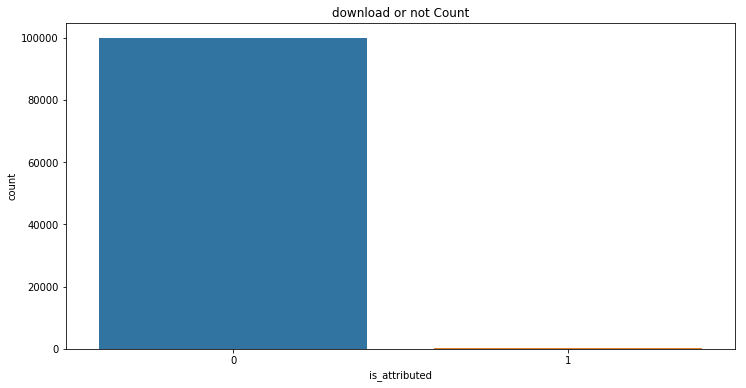

In [7]:
plt.figure(figsize=(12, 6))
click_count = sample_df.groupby('is_attributed', as_index=False)['ip'].count()
click_count = click_count.rename(columns ={'ip':'count'})
sns.barplot(x='is_attributed', y='count', data= click_count);
plt.title('download or not Count');
click_count.head()

Since the number of rows that app was downloaded after clicking is quite small, it is actually 227, so it is only about 0.23%.

Let's see the number of each unique value next.

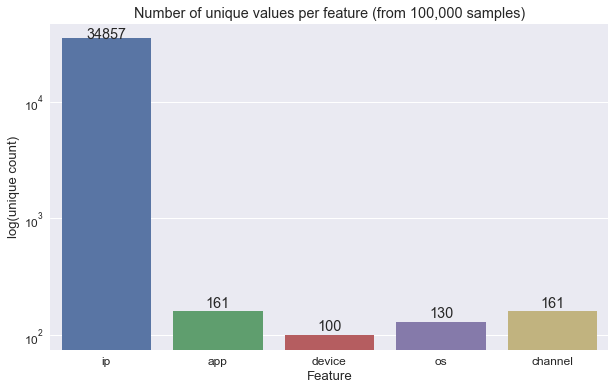

In [8]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(sample_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 100,000 samples)');
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
        height + 10,
        uniq,
        ha="center") 

The ip address is the most number, and the others are within 100 to 200.

## Clicks and downloads per hour and minute

If Developers of competing applications conduct frand click, fraud clicks may be concentrated on the time people are sleeping.
Convert 'click_time' column to datetime type, make new columns, 'day', 'hour' and 'minute'.


By the way, November 6 to 9 are weekdays and no special events in China.

In [9]:
sample_df['click_time_dt']= pd.to_datetime(sample_df['click_time'])
dt= sample_df['click_time_dt'].dt
sample_df['day'] = dt.day.astype('uint8')
sample_df['hour'] = dt.hour.astype('uint8')
sample_df['minute'] = dt.minute.astype('uint8')

Let's divide the data whther download or not.

In [10]:
dll_df = sample_df[sample_df['is_attributed'] == 1]
not_dll_df = sample_df[sample_df['is_attributed'] == 0]

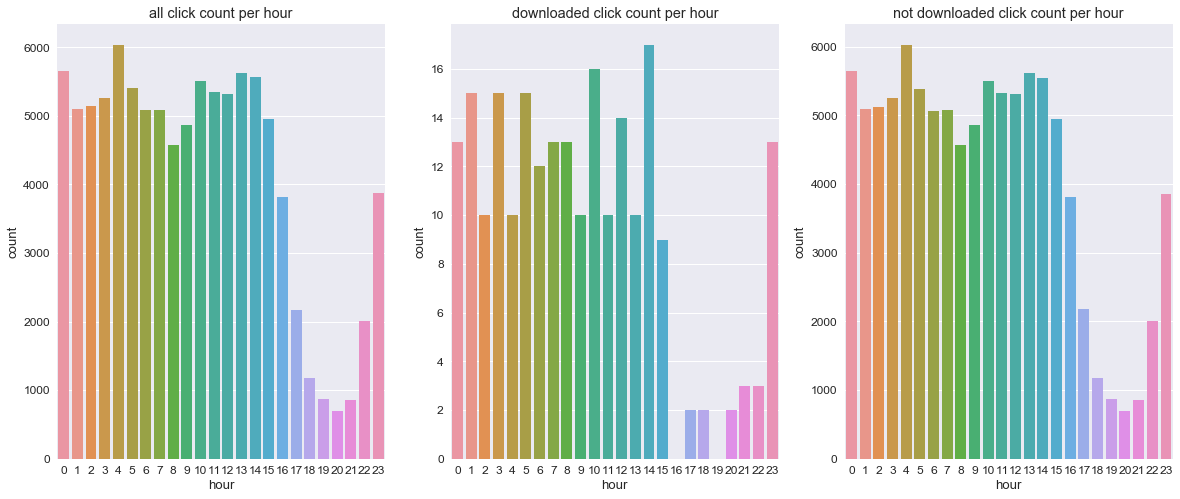

In [11]:
fig ,ax = plt.subplots(1,3, figsize= (20, 8))

sns.countplot(x='hour', data=sample_df, ax=ax[0]);
sns.countplot(x='hour', data=dll_df, order=[i for i in range(24)] , ax=ax[1]);
sns.countplot(x='hour', data=not_dll_df,  ax=ax[2]);
ax[0].set_title('all click count per hour');
ax[1].set_title('downloaded click count per hour');
ax[2].set_title('not downloaded click count per hour');


We are plotting the total number of clicks per hour, the number of clicks downloaded and the number of clicks not downloaded respectively.
The number of clicks are commonly falling from 18 to 22 o'clock, but there is no big difference in the three graphs.


Let's plot the download rate for the number of clicks per hour.

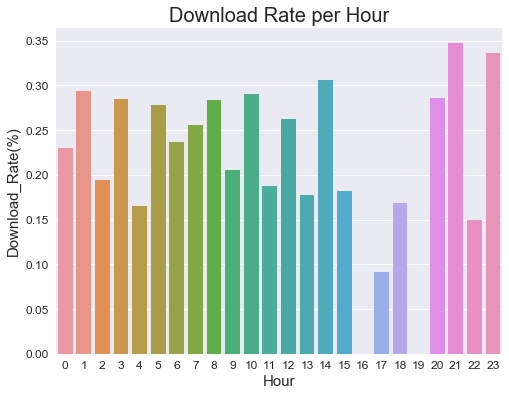

In [12]:
count_per_hour = sample_df.groupby('hour', as_index = False).count()
count_per_hour = count_per_hour[['hour', 'app', 'attributed_time']]
count_per_hour = count_per_hour.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
count_per_hour['download_rate'] = count_per_hour['download_count'] / count_per_hour['click_count'] * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='hour', y='download_rate', data=count_per_hour);
plt.ylabel('Download_Rate(%)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
ax.set_title('Download Rate per Hour', fontsize = 20);

In the evening, the number of downloads is declining, and is declining too.
This is not a very good graph.

Because the download rate is too small, if one download column is added, the result will change dramatically.

If click frauder click on the computer automatically, clicks may have occurred every ten minutes.

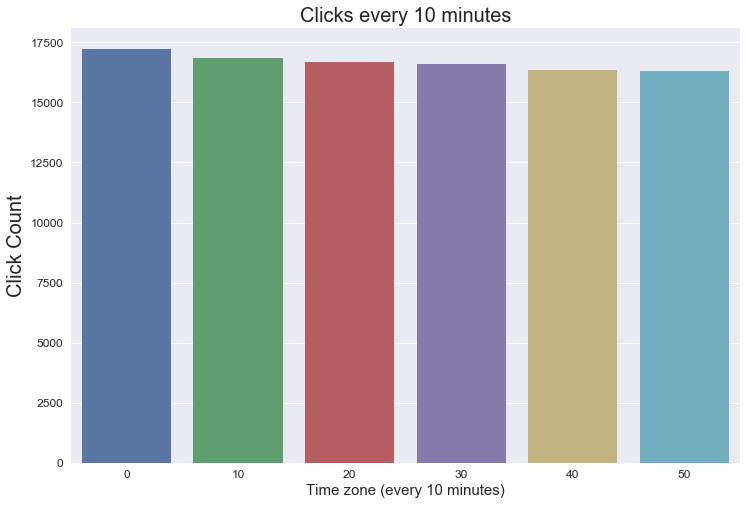

In [13]:
sample_df['minute_band'] = pd.cut(sample_df['minute'], 6)
minute_df = sample_df.groupby('minute_band', as_index=False).count().sort_values(by='minute_band', ascending=True) [['minute_band', 'ip']]

rename_dict = {}
minute_band_name = ['0', '10', '20', '30', '40', '50']
for minute_band,col in zip(minute_band_name, minute_df['minute_band']):
    rename_dict[col] = minute_band

minute_df = minute_df.rename(index=rename_dict)

def rename_minute_band(s):
    return rename_dict[s]

minute_df ['minute_band']= minute_df['minute_band'].map(rename_minute_band)

plt.figure(figsize=(12,8))
sns.barplot(x='minute_band', y='ip' ,data=minute_df)
plt.title("Clicks every 10 minutes", fontsize =20)
plt.xlabel('Time zone (every 10 minutes)',fontsize=15)
plt.ylabel('Click Count',fontsize=20)
plt.show()


We saw number of click per hour and 10 minutes, but no noticeable difference appeared.
It seems that the click fraunder is skillfully doing cheating more than I thought.

## Correlation of each variable

Now we look at the correlation of each variable.

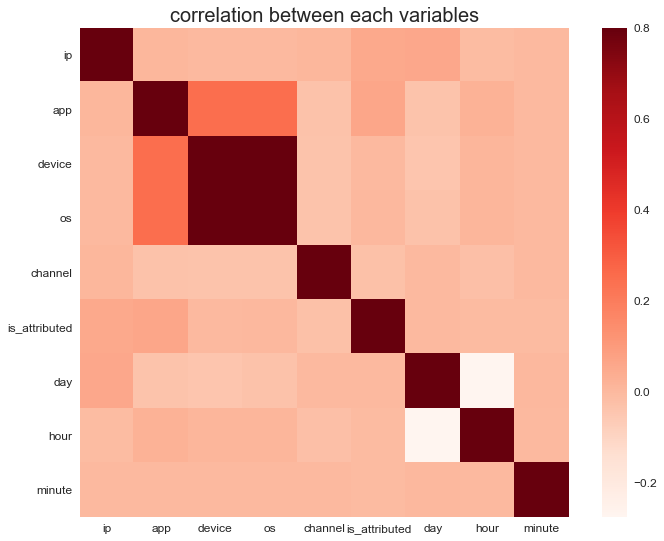

In [14]:
corrmat = sample_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='Reds',vmax=.8, square=True, ax=ax);
ax.set_title("correlation between each variables", fontsize= 20);

There seems to be a strong correlation between OS, device, and application, but we can not find anything strongly correlated with the 'is_attrained' variable.
If I had to choose IP　and application.

Now I read [Actual condition of chilk frauder](https://www.gizmodo.jp/2017/06/thai-click-fraud-farm-busted-using-wall-of-iphones.html),
I made the following four guesses

1. Did they click on a large number with the same ip address?
1. Did they click on the same device, OS?
1. If Developers of competing applications conduct click fraud, is the number of clicks increased with a specific application?
1. If Ad network companies applications conduct click fraud, is the number of clicks increased with a specific channel?

## 1. Did they click on a large number with the same ip address?

count    100000.000000
mean      91255.879670
std       69835.553661
min           9.000000
25%       40552.000000
50%       79827.000000
75%      118252.000000
max      364757.000000
Name: ip, dtype: float64


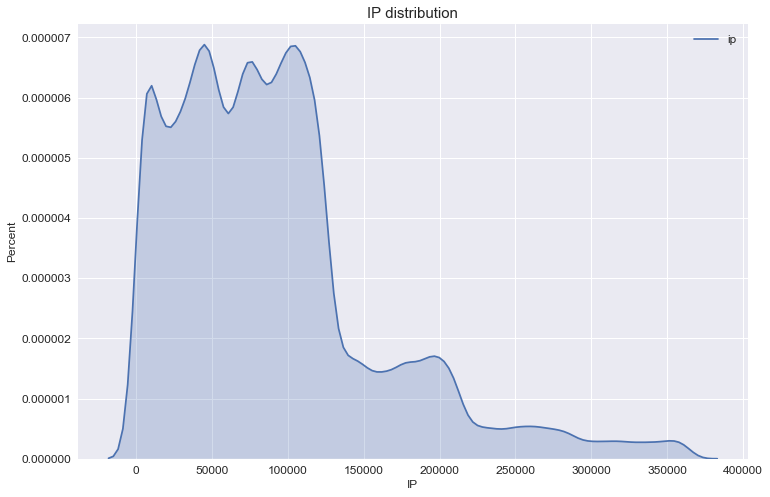

In [15]:
# Check the ip address distribution
print(sample_df['ip'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['ip'], shade=True)
plt.title('IP distribution', fontsize = 15)
plt.xlabel('IP', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

It is concentrated around 0 to 10,000.
If it is the original ip address (eg. 192.102.10.52), you can find place information. but this data have encoded, so It is not possible to find meaning in the numerical value of ip address.

Next, let's count the number of each ip address.

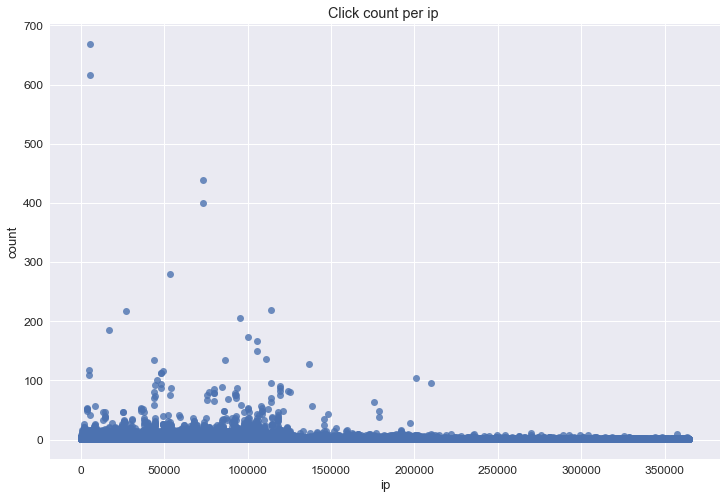

In [16]:
click_ip_count = sample_df.groupby('ip', as_index= False)['device'].aggregate('count').sort_values('device', ascending=False)
click_ip_count = click_ip_count.rename(columns={'device':'count'})

plt.figure(figsize=(12,8))
sns.regplot(x='ip', y='count', fit_reg=False, data=click_ip_count)
plt.title("Click count per ip ")
plt.show()

Next, we'll display it again except the ip with 20 clicks or less.

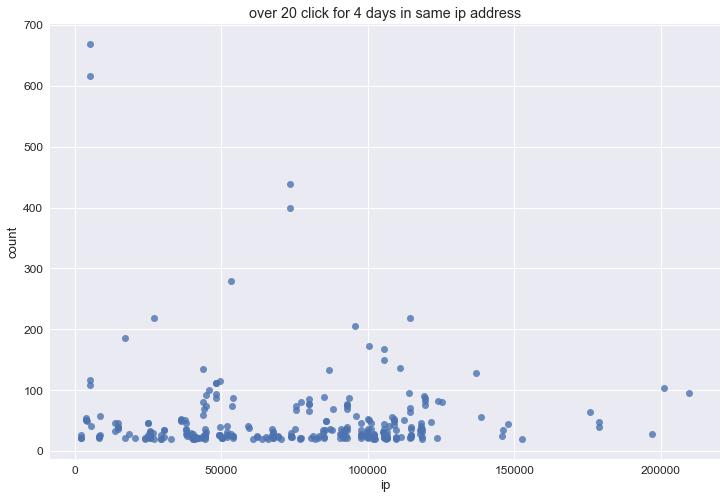

In [17]:
plt.figure(figsize=(12,8))
sns.regplot(x='ip', y='count', fit_reg=False, data=click_ip_count[click_ip_count['count']>19])
plt.title('over 20 click for 4 days in same ip address')
plt.show()

I rarely tap ads more than 20 times in 4 days with my smartphone.

What is plotted here may be fraud click.

I will continue a little more.
Let's arrange the top ten things with many clicks with the same ip address.

In [18]:
ip_click_ranking = sample_df.groupby('ip', as_index = False).count().sort_values(by = 'app', ascending=False)
ip_click_ranking = ip_click_ranking[['ip', 'app']]
ip_click_ranking = ip_click_ranking.rename(columns={'app':'click_count'})
ip_click_ranking.head(10)

,ip,click_count
926,5348,669
918,5314,616
12833,73487,439
12839,73516,399
9385,53454,280
20021,114276,219
4639,26995,218
16703,95766,205
2990,17149,186
17488,100275,173


Let's see the click time of ip "5348" with the most clicks on trial.

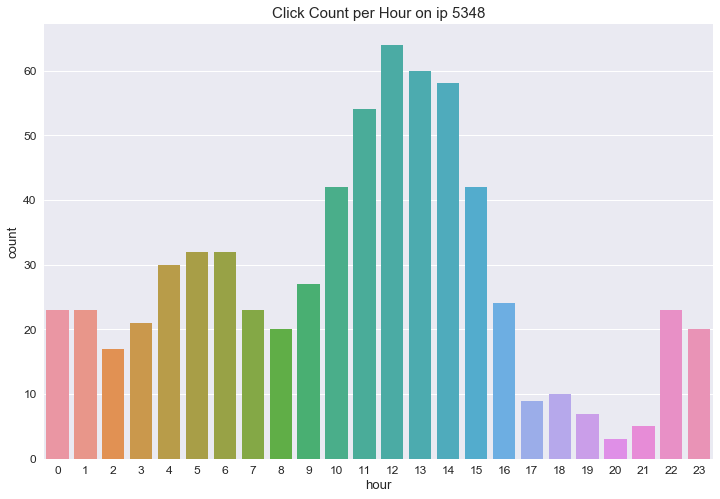

In [19]:
sample_df[sample_df['ip'] == 5348].sort_values(by='click_time', ascending=True).head(20)

plt.figure(figsize=(12,8))
sns.countplot(x='hour', data=sample_df[sample_df['ip'] == 5348]);
plt.title('Click Count per Hour on ip 5348', fontsize=15)
plt.show()

It is amazing! This ip address's device were clicked all day without sleeping.
This is speculative, but smells of fraudulent clicks.

Let's look at the number of downloads of IP with many clicks.

In [20]:
ip_click_download = sample_df.groupby('ip', as_index = False).sum().sort_values(by='app', ascending = False).reset_index()
ip_click_download = ip_click_download[['ip', 'app', 'is_attributed']]
ip_click_download = ip_click_download.rename(columns={'is_attributed': 'download_count', 'app': 'click_count'})

ip_click_download.head(30)

,ip,click_count,download_count
0,5314,10086,3
1,5348,9478,3
2,73487,4809,0
3,73516,4428,0
4,53454,3548,0
5,114276,3243,0
6,26995,3215,0
7,86767,3003,0
8,17149,2993,0
9,105475,2513,0


Oh no! IP address with many clicks has mostly **0 downloads**.
So IP address is effective for judging whether it is an illegal click.

## 2.Did they click on the same device, OS?

Now let's look at the number of clicks on the same device, OS. 

Click frauder may have many cheap device, and their device may be not updated.
There are many possibilities to use a specific device, OS.

Let's first look at the number of clicks for each device id.

count    100000.000000
mean         21.771250
std         259.667767
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3867.000000
Name: device, dtype: float64


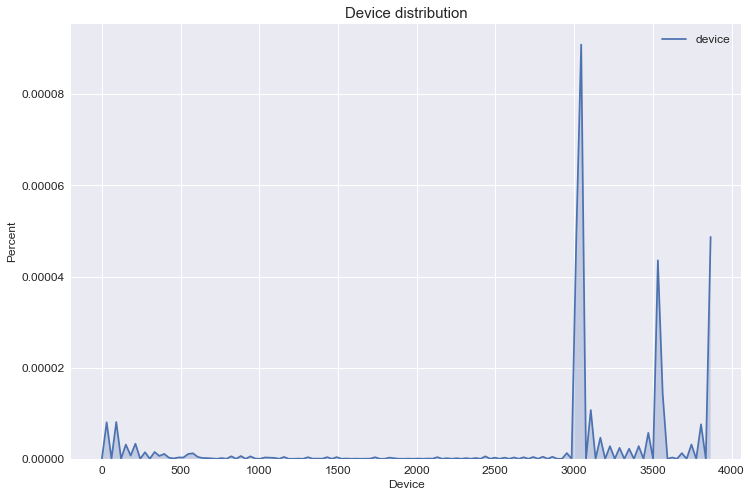

In [21]:
print(sample_df['device'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['device'], shade=True)
plt.title('Device distribution', fontsize = 15)
plt.xlabel('Device', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

We find that the click rate on a specific device is high.

Let's take a look at the top 10 download rate of the device with many clicks.

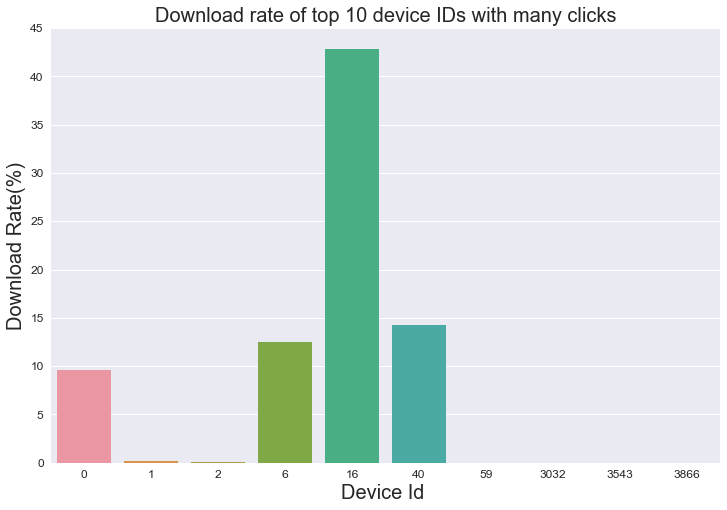

,device,click_count,download_count,download_rate
0,1,94338,146,0.154763
1,2,4345,2,0.046030
2,0,541,52,9.611830
3,3032,371,0,0.000000
4,3543,151,0,0.000000
5,3866,93,0,0.000000
6,59,12,0,0.000000
7,6,8,1,12.500000
8,40,7,1,14.285714
9,16,7,3,42.857143


In [22]:
dll_cnt_device = sample_df.groupby('device', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_device = dll_cnt_device[['device', 'is_attributed']]
dll_cnt_device = dll_cnt_device.rename(columns={'is_attributed': 'download_count'})

click_cnt_device = sample_df.groupby('device', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_device = click_cnt_device[['device', 'app']]
click_cnt_device = click_cnt_device.rename(columns={'app': 'click_count'})

device_click_download_df = pd.merge(click_cnt_device, dll_cnt_device, on='device') 

device_click_download_df['download_rate'] = device_click_download_df['download_count']/ device_click_download_df['click_count'] * 100 


plt.figure(figsize=(12,8))
sns.barplot(x='device', y='download_rate', data=device_click_download_df[:10])
plt.xlabel("Device Id ", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 device IDs with many clicks", fontsize=20)
plt.show()

device_click_download_df.head(10)

Device ids other than no 0, 6, 16, 40 are not downloaded.

Likewise let's look at the number of clicks per OS.

count    100000.000000
mean         22.818280
std          55.943136
min           0.000000
25%          13.000000
50%          18.000000
75%          19.000000
max         866.000000
Name: os, dtype: float64


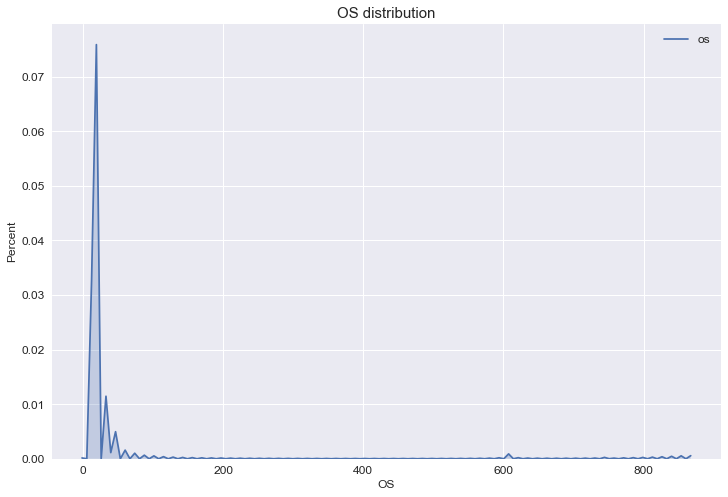

In [23]:
# 　check os distribution
print(sample_df['os'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['os'], shade=True)
plt.title('OS distribution', fontsize = 15)
plt.xlabel('OS', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

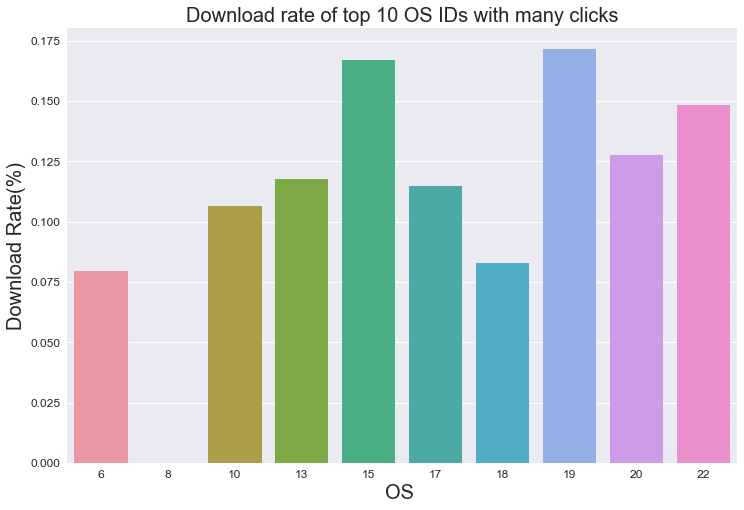

,os,click_count,download_count,download_rate
0,19,23870,41,0.171764
1,13,21223,25,0.117797
2,17,5232,6,0.114679
3,18,4830,4,0.082816
4,22,4039,6,0.148552
5,10,2816,3,0.106534
6,8,2775,0,0.000000
7,6,2520,2,0.079365
8,15,2396,4,0.166945
9,20,2347,3,0.127823


In [24]:
dll_cnt_os = sample_df.groupby('os', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_os = dll_cnt_os[['os', 'is_attributed']]
dll_cnt_os = dll_cnt_os.rename(columns={'is_attributed': 'download_count'})

click_cnt_os = sample_df.groupby('os', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_os = click_cnt_os[['os', 'app']]
click_cnt_os = click_cnt_os.rename(columns={'app': 'click_count'})

os_click_download_df = pd.merge(click_cnt_os, dll_cnt_os, on='os') 

os_click_download_df['download_rate'] = os_click_download_df['download_count']/ os_click_download_df['click_count'] * 100 

os_click_download_df.head(10)

plt.figure(figsize=(12,8))
sns.barplot(x='os', y='download_rate', data=os_click_download_df[:10])
plt.xlabel("OS ", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 OS IDs with many clicks", fontsize=20)
plt.show()

os_click_download_df.head(10)

Here is only the 8 OS Only the number of downloads is 0, no noticeable difference is not seen.

## 3.If Developers of competing applications conduct click fraud, is the number of clicks increased with a specific application?

Next, let's see the number of clicks for each application.

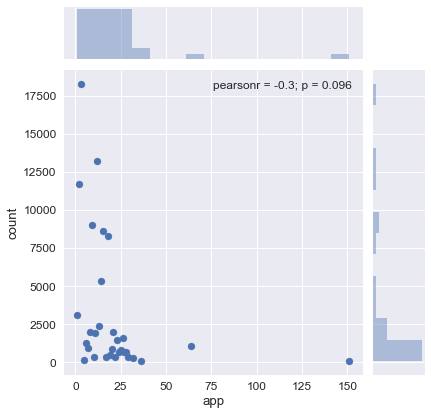

In [25]:
click_ip_count = sample_df.groupby('app', as_index= False)['device'].aggregate('count').sort_values('device', ascending=False)
click_ip_count = click_ip_count.rename(columns={'device':'count'})
click_ip_count = click_ip_count[click_ip_count['count'] > 100]

plt.figure(figsize=(12,8))
sns.jointplot('app', 'count', data=click_ip_count)
plt.show()

There are extremely clicked apps. These apps is fraud click target.
Click fraunder who received a request from a competing application developer did fraud clicks in order to hide the advertisements of specific apps .

## 4. If Ad network companies applications conduct click fraud, is the number of clicks increased with a specific channel?

Next, let's take a look at the number of clicks per channel.

If the advertisement publisher make an fraud click to gain profit, we can see data that the number of clicks for a specific channel is large.

count    100000.000000
mean        268.832460
std         129.724248
min           3.000000
25%         145.000000
50%         258.000000
75%         379.000000
max         498.000000
Name: channel, dtype: float64


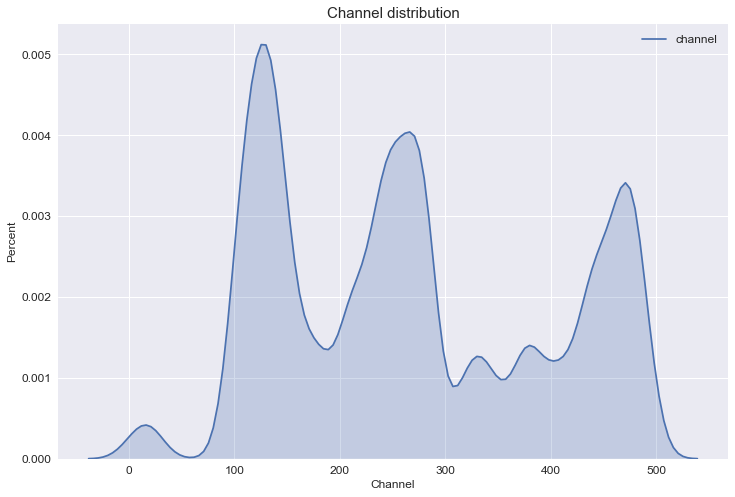

In [26]:
#  check chennel distribution
print(sample_df['channel'].describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(sample_df['channel'], shade=True)
plt.title('Channel distribution', fontsize = 15)
plt.xlabel('Channel', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

There are many clicks on a specific channel, but this may be just a large frequency of advertisements.

Let's see the top ten channels with many clicks.

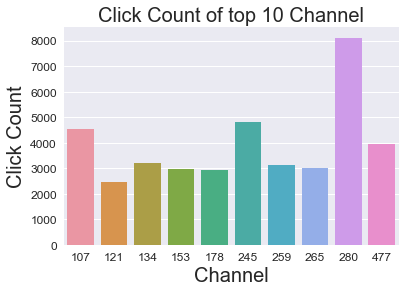

,channel,click_count
77,280,8114
64,245,4802
14,107,4543
146,477,3960
33,134,3224


In [27]:
click_cnt_channel = sample_df.groupby('channel', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_channel = click_cnt_channel[['channel', 'app']]
click_cnt_channel = click_cnt_channel.rename(columns={'app': 'click_count'})

sns.barplot(x='channel', y='click_count', data=click_cnt_channel.sort_values(by='click_count', ascending=False)[:10])
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Click Count", fontsize=20)
plt.title("Click Count of top 10 Channel", fontsize=20)
plt.show()

click_cnt_channel.head()


There are many clicks in No.280 channel in particular. Other channels are nearly flat.

Let's also look at the download rate of this top ten channels with many clicks.

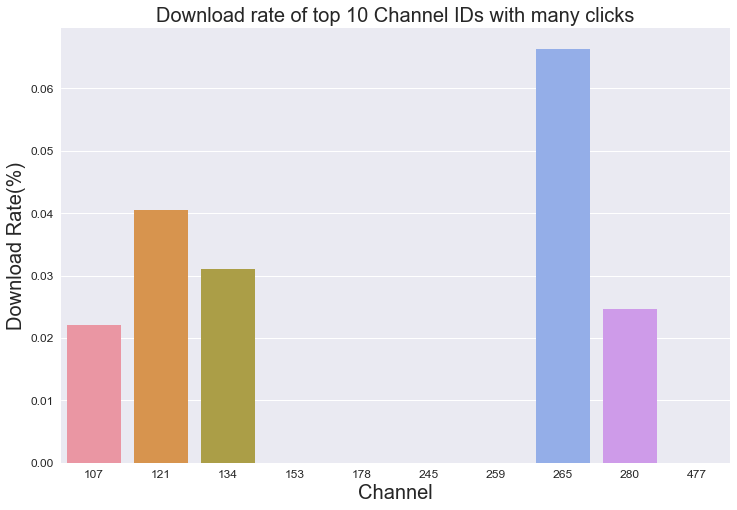

,channel,click_count,download_count,download_rate
0,280,8114,2,0.024649
1,245,4802,0,0.000000
2,107,4543,1,0.022012
3,477,3960,0,0.000000
4,134,3224,1,0.031017
5,259,3130,0,0.000000
6,265,3013,2,0.066379
7,153,2954,0,0.000000
8,178,2936,0,0.000000
9,121,2472,1,0.040453


In [28]:
dll_cnt_channel = sample_df.groupby('channel', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_channel = dll_cnt_channel[['channel', 'is_attributed']]
dll_cnt_channel = dll_cnt_channel.rename(columns={'is_attributed': 'download_count'})

channel_click_download_df = pd.merge(click_cnt_channel, dll_cnt_channel, on='channel') 

channel_click_download_df['download_rate'] = channel_click_download_df['download_count']/ channel_click_download_df['click_count'] * 100 

plt.figure(figsize=(12,8))
sns.barplot(x='channel', y='download_rate', data=channel_click_download_df[:10])
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 Channel IDs with many clicks", fontsize=20)
plt.show()

channel_click_download_df.head(10)

Some channels have many clicks but not downloaded at all.

## Summary

- Ip with regular clicks is more likely to be fraudlent. Obviously it is not how ordinary people use it.
- Some device have many clicks but no download.
- As I guessed from the purpose of frauders, variable 'app' and 'channel' are related to fraudulent click.

### Reflection point

- Anyway it took a lot of time. (Decide what to plot, coding, and etc...)

### Improvements

- Don't overdo any conclusions. I will plot with ease
- Read many kernel and stock the pattern of the plot.


# Any questions and comments are appreciated. 
